# Scarlet Function

Output function:
    
    for every band, output 1 fits file (name of input file, append _scarlet.fits at end)
    ... 3 fits files per 3 bands
    
    in each fits file:
        -have image itself (first header)
        - n headers for every n source detected in code
        - in every header will have an image of a model of that source and only that source
               this model will NOT be same size of full image. it'll be small cutout 
               thus for header of file imagename for those small cutouts need to put entry called bbox (4 vector) w/ X, Y, WIDTH, HEIGHT  ... tells you where cutout is in image
               
        - Set entry name (categoryID) to 1 for all (b/c all galaxies)
        
        
        From Fits files Colin can generate exact data structure for detectron.

In [1]:
import sys
sys.path.insert(1, '/home/paleo2/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/')

In [78]:
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+gfde109a
1.20.2
1.1.1


In [2]:
def get_tract_patch_from_coord(coord):

    from astropy.coordinates import SkyCoord, match_coordinates_sky

    f = 'data/hsc/tracts_patches_UD-COSMOS.txt'

    lines = open(f).read().splitlines()
    # Keep only field centers
    centers = [l for l in lines if "Center (RA, Dec):" in l and 'Patch:' in l]
    # Extract tracts and patches at each line
    tracts = [int(c.split('Tract: ')[1].split('Patch: ')[0]) for c in centers]
    patches = [c.split('Patch: ')[1].split('Center ')[0] for c in centers]
    patches = [tuple(map(int, p.split(','))) for p in patches]
    # Extract coord of field centers
    center_coords = [c.split('Center (RA, Dec): ')[1] for c in centers]
    ra = [float(c.replace('(', '').split(',')[0]) for c in center_coords]
    dec = [float(c.replace(')', '').split(',')[1]) for c in center_coords]
    # Convert to SkyCoord
    center_coords = SkyCoord(ra, dec, unit='deg')
    # Find closest field center to requested coordinate
    idx, d2d, d3d = match_coordinates_sky(coord, center_coords)
    # No sep contraint
    tract = tracts[idx]
    patch = patches[idx]
    
    return tract, patch

WIll also have to create train, validation, and test set (split up images combos)

Run on train and validation but NOT test set.

In [93]:
%config InlineBackend.figure_format = 'retina' #for MacOS, make plots crisp

# Import necessary packages and setup
import os
import numpy as np
import scarlet
import sep 
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

from astropy.modeling.models import Ellipse2D
from astropy.coordinates import Angle
from matplotlib.patches import Ellipse

import math

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

def get_hsc_data(dirpath, filters=['g','r','i'], tract=10054, patch=[0,0], coord=None, cutout_size=[128, 128], plot_image=False):
    """
    Get HSC data given tract/patch info or SkyCoord
    
    Parameters
    ----------
    dirpath : str
        Path to HSC image file directory
    bands : list 
        A list of filters for your images. E.g. ['G', 'R', 'I']. Must be uppercase to match the 
        default filename of the HSC images.
    tract  : int
        An integer used for specifying the tract. E.g. 10054
    patch : [int, int]
        Patch #,# 
    coord  : SkyCoord
        Astropy SkyCoord, when specified, overrides tract/patch info and attempts to lookup HSC filename from ra, dec
        
        
    The image filepath is in the form:
        {dirpath}/deepCoadd/HSC-{filter}/{tract}/{patch[0]},{patch[1]}/calexp-HSC-{filter}-{tract}-{patch[0]},{patch[1]}.fits.gz
    
    Returns
    -------
    hdu : Astropy HDUData
        HDU data from HSC file
    """
    
    filters = [f.upper() for f in filters]
    
    if coord is not None:
        import warnings
        warnings.warn("Overriding tract/patch info and looking for HSC file at requested coordinates.")
        tract, patch = get_tract_patch_from_coord(coord)
        
    datas = []

    for f in filters:
        filepath = os.path.join(dirpath, f'HSC-{f}/{tract}/{patch[0]},{patch[1]}/calexp-HSC-{f}-{tract}-{patch[0]},{patch[1]}.fits.gz')
        
        print(f'Loading "{filepath}".')
        
        obs_hdul = fits.open(filepath)
        data = obs_hdul[1].data
        wcs = WCS(obs_hdul[1].header)
                
        # TODO: Split the data into sub-arrays if too large?
        
        # Cutout data at center of patch (coord=None) or at coord (if specified)
        if cutout_size is not None:
            # Use coord for center position if specified
            if coord is None:
                shape = np.shape(data)
                position = (shape[0]/2, shape[1]/2)
            else:
                position = coord
            data = Cutout2D(data, position=position, size=cutout_size, wcs=wcs).data
            
        datas.append(data)
        
    datas = np.array(datas)
        
    # Display one image cube
    if plot_image:
        fig, ax = plt.subplots(1, 1, figsize=(9,9))
        norm = scarlet.display.AsinhMapping(minimum=0, stretch=1, Q=5)
        img_rgb = scarlet.display.img_to_rgb(datas, norm=norm)
        ax.imshow(img_rgb)
        ax.axis('off')

    obs_hdu = fits.PrimaryHDU(datas)
    return obs_hdu.data


def plot_stretch_Q(datas, stretches=[0.01,0.1,0.5,1], Qs=[1,10,5,100]):
    """
    Plots different normalizations of your image using the stretch, Q parameters. 
    
    Parameters
    ----------
    stretches : array
        List of stretch params you want to permutate through to find optimal image normalization.
        Default is [0.01, 0.1, 0.5, 1]
    Qs : array
        List of Q params you want to permutate through to find optimal image normalization.
        Default is [1, 10, 5, 100]
        
    Code adapted from:
        https://pmelchior.github.io/scarlet/tutorials/wavelet_model.html
        https://pmelchior.github.io/scarlet/tutorials/multiresolution.html
        
    Returns
    -------
    fig : Figure object
    
    """
    
    fig, ax = plt.subplots(len(stretches), len(Qs), figsize=(9,9))
    for i, stretch in enumerate(stretches):
        for j, Q in enumerate(Qs):
            asinh = scarlet.display.AsinhMapping(minimum=0, stretch=stretch, Q=Q)
            # Scale the RGB channels for the image
            img_rgb = scarlet.display.img_to_rgb(datas, norm=asinh)
            ax[i][j].imshow(img_rgb)
            ax[i][j].set_title("Stretch {}, Q {}".format(stretch, Q))
            ax[i][j].axis('off')
            
    return fig


def make_catalog(datas, lvl=4, wave=True, subtract_background=False, segmentation_map=False, maskthresh=5.0):
    """
    Creates a detection catalog by combining low and high resolution data
    
    Parameters
    ----------
    datas: array
        array of Data objects
    lvl: int
        detection lvl
    wave: Bool
        set to True to use wavelet decomposition of images before combination
    subtract_background : Bool
        if you want to subtract the background and retrieve an estimate, change to True. But default 
        is False because HSC images are already background subtracted.
        
    Code adapted from https://pmelchior.github.io/scarlet/tutorials/wavelet_model.html
    
    Returns
    -------
    catalog: sextractor catalog
        catalog of detected sources
    bg_rms: array
        background level for each data set
    """
    
    if type(datas) is np.ndarray:
        hr_images = datas / np.sum(datas, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(hr_images, axis=0)
    else:
        data_lr, data_hr = datas
        # Create observations for each image
        # Interpolate low resolution to high resolution
        interp = interpolate(data_lr, data_hr)
        # Normalisation of the interpolate low res images
        interp = interp / np.sum(interp, axis=(1, 2))[:, None, None]
        # Normalisation of the high res data
        hr_images = data_hr.images / np.sum(data_hr.images, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(interp, axis=0) + np.sum(hr_images, axis=0)
        detect_image *= np.sum(data_hr.images)
    if np.size(detect_image.shape) == 4:
        if wave:
            # Wavelet detection in the first three levels
            wave_detect = Starlet(detect_image.mean(axis=0), lvl=5).coefficients
            wave_detect[:, -1, :, :] = 0
            detect = scarlet.Starlet(coefficients=wave_detect).image
        else:
            # Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = scarlet.Starlet(detect_image).coefficients
            detect = wave_detect[0][0] + wave_detect[0][1] + wave_detect[0][2]
        else:
            detect = detect_image
    
    bkg = sep.Background(detect)
    # Set the limit on the number of sub-objects when deblending. Default is 1024
    sep.set_sub_object_limit(100000)
    
    # Extract detection catalog with segmentation maps!
    # Can use this to retrieve ellipse params
    catalog = sep.extract(detect, lvl, err=bkg.globalrms, segmentation_map=segmentation_map, maskthresh=5.0)
    
    #print(catalog.dtype.names)
    
    # Estimate background
    if subtract_background == True:
        if type(datas) is np.ndarray:
            bkg_rms = scarlet.wavelet.mad_wavelet(datas)

        else:
            bkg_rms = []
            for data in datas:
                bkg_rms.append(scarlet.wavelet.mad_wavelet(data.images))
                
    else:
        bkg_rms = None

    return catalog, bkg_rms

    
def run_scarlet(datas, filters, stretch=0.1, Q=5, sigma_model=1, sigma_obs=5,
                subtract_background=False, max_chi2 = 1000,
                plot_wavelet=False, plot_likelihood=True, plot_scene=False,
                plot_sources=False, plot_first_isolated_comp=False):
    
    """ Run P. Melchior's scarlet (https://github.com/pmelchior/scarlet) implementation 
    for source separation. This function will create diagnostic plots, a source detection catalog, 
    and fit a model for all sources in the observation scene (image).

    Parameters
    ----------
    subtract_background : boolean
        Whether or not to estimate and subtract the background (often background is already subtracted)
        Detault is False
    plot_wavelet_transform : boolean
        Plot starlet wavelet transform and inverse transform at different scales. 
        NOTE: Not really useful at large image sizes (> ~few hundred pixels length/height)
        Default is False
    plot_detections : boolean
        Plot detection catalog results. Default is False
    plot_likelihood : boolean
        Plot likelihood as function of iterations from Blend fit function. Default is True
    plot_full_scene : boolean
        Plot full scene with the model, rendered model, observation, and residual. Default is False.
    plot_all_sources : boolean
        Plot the model, rendered model, observation, and spectrum across channels for each object. 
        WARNING: dumb to do this with a large image with many sources! Default is False
    plot_first_isolated_comp : boolean
        Plot the subtracted and isolated first (or any) starlet component. Recommended for finding a bright
        component. Default is False.


    Return
    -------
    FITS file with...
    TODO: fill this out once I get the exact fits file output generated to Colin's liking 
    """
    
    norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
        
    # Generate source catalog using wavelets
    catalog, bg_rms_hsc = make_catalog(datas, 3, wave=True, subtract_background=subtract_background)
    # If image is already background subtracted, bg_rms_hsc will be None
    if bg_rms_hsc is None:
        weights = np.ones_like(datas)
    else:
        # Set weights to all ones
        weights = np.ones_like(datas) / (bg_rms_hsc**2)[:, None, None]
    
    print("Source catalog found ", len(catalog), "objects")
    
    # Plot wavelet transform at different scales
    if plot_wavelet == True:
        # Declare a starlet object (and performs the transform)
        Sw = scarlet.Starlet(datas, lvl=5, direct=True)
        # This is the starlet transform as an array
        w = Sw.coefficients
        # The inverse starlet transform of w (new object otherwise, the tranform is not used)
        iw = Sw.image

        # TODO: Clean this code up using plt.subplots()
        # The wavelet transform of the first slice of images in pictures
        lvl = w.shape[1]
        plt.figure(figsize=(lvl*5+5,5))
        plt.suptitle('Wavelet coefficients')
        for i in range(lvl):
            plt.subplot(1, lvl, i+1)
            plt.title('scale' + str(i+1))
            plt.imshow(w[0,i], cmap='inferno')
            plt.colorbar()
        plt.show()

        # Making sure we recover the original image
        plt.figure(figsize=(30,10))
        plt.subplot(131)
        plt.title('Original image', fontsize=20)
        plt.imshow(datas[0], cmap='inferno')
        plt.colorbar()
        plt.subplot(132)
        plt.title('Starlet-reconstructed image', fontsize=20)
        plt.imshow(iw[0], cmap='inferno')
        plt.colorbar()
        plt.subplot(133)
        plt.title('Absolute difference', fontsize=20)
        plt.imshow((np.abs(iw[0]-datas[0])), cmap='inferno')
        plt.colorbar()
        plt.show()
        
    # Define model frame and observations:
    model_psf = scarlet.GaussianPSF(sigma=sigma_model, boxsize=100)
    model_frame = scarlet.Frame(datas.shape, psf=model_psf, channels=filters)

    observation_psf = scarlet.GaussianPSF(sigma=sigma_obs)
    observation = scarlet.Observation(datas, psf=observation_psf, weights=weights, channels=filters).match(model_frame)        
          
    # Initialize starlet sources to be fit. Assume extended sources for all because 
    # we are not looking at all detections in each image
    
    # TODO: Plot chi2 vs. binned size and mag. Implement conidition if chi2 > xxx then
    # add another component until larger sources are modeled well
    print("Initializing starlet sources to be fit.")
        
    # Compute radii and spread of sources
    Rs = np.sqrt(catalog['a']**2 + catalog['b']**2)
    spread = Rs/sigma_obs
    
    # Array of chi^2 residuals computed after fit on each model
    chi2s = np.zeros(len(catalog))
    
    # Run through twice, adding scarlets if needed on 2nd iteration
    for i in range(2):
        
        # Loop through detections in catalog
        starlet_sources = []
        for k, src in enumerate(catalog):

            # Is the source compact relative to the PSF?
            if spread[k] < 1:
                compact = True
            else:
                compact = False

            if chi2s[k] > max_chi2:
                # TODO: Why does this seem to mess things up so badly?
                #new_source = scarlet.StarletSource(model_frame, (src["x"], src["y"]),
                #                                   observation, starlet_thresh=3)
                new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']),
                                                    observation, K=3, flux_percentiles=[5, 25], compact=False)
            else:
                new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']),
                                                    observation, K=1, compact=compact)

            starlet_sources.append(new_source)

        # Create and fit Blend model. Go for 200 iterations,
        # but will end early if likelihood and constraints converge
        print(f"Fitting Blend model.")
        try:
            starlet_blend = scarlet.Blend(starlet_sources, observation)
            it, logL = starlet_blend.fit(200, e_rel=1e-4)
            print(f"Scarlet ran for {it} iterations to logL = {logL}")

        # Catch any exceptions like no detections
        except AssertionError as e1:
            print(f"Length of detection catalog is {len(catalog)}.")

        if plot_likelihood == True:
            scarlet.display.show_likelihood(starlet_blend)
            plt.show()

        # Compute reduced chi^2 for each rendered sources
        for k, src in enumerate(starlet_sources):
            
            model = src.get_model(frame=model_frame)
            model = observation.render(model)
            res = datas - model

            # Compute in bbox only
            res = src.bbox.extract_from(res)
            chi2s[k] = np.sum(res**2)
            
            #plt.figure(figsize=(5,5))
            #model_rgb = scarlet.display.img_to_rgb(res, norm=norm)
            #plt.title(chi2s[k])
            #plt.imshow(model_rgb)
            #plt.show()
            
        # If all chi2 residuals are acceptable, move on
        if np.all(chi2s < max_chi2):
            break

    # Render the entire scene
    # Plot the model, observation, asinh stretch and the residuals with a linear stretch
    if plot_scene == True:
        fig = scarlet.display.show_scene(starlet_sources, observation=observation, norm=norm,
                                         show_model=False, show_rendered=True, show_observed=True,
                                         show_residual=True, add_labels=False, add_boxes=True)
        
        for ax in fig.axes:
        
            # Plot sep ellipse around all sources from the detection catalog
            for k, src in enumerate(catalog):
                
                # See https://sextractor.readthedocs.io/en/latest/Position.html
                e = Ellipse(xy=(src['x'], src['y']),
                            width=6*src['a'],
                            height=6*src['b'],
                            angle=np.rad2deg(src['theta']))

                e.set_facecolor('none')
                e.set_edgecolor('white')
            
                ax.add_artist(e)
        
            ax.axis('off')
            
        fig.subplots_adjust(wspace=0.01)
        plt.show()

    # Plot each for each source
    if plot_sources == True:
        scarlet.display.show_sources(starlet_sources, observation, norm=norm,
                                     show_rendered=True, show_observed=True, add_boxes=True)
        plt.show()
         
    return starlet_sources, model_frame


def write_scarlet_results(datas, starlet_sources, model_frame):
    ##############################
    # SAVE RESULTS!!!
    # Save full image
    save_hdu = fits.PrimaryHDU(data=img_rgb) # Primary HDU is full image
    header = save_hdu.header # each full image has a header with height, width of image
    header['HEIGHT'] = img_rgb.shape[0]
    header['WIDTH'] = img_rgb.shape[1]

    # Save each model source
    save_starlet_source_list = []

    for k in range(len(starlet_sources)):

        # Get each model, make into image
        my_starlet_source = starlet_sources[k].get_model(frame=model_frame)
        my_starlet_source = observation.render(my_starlet_source)
        starlet_source_img_rgb = scarlet.display.img_to_rgb(my_starlet_source, norm=norm)

        # Save model with location info (relative to full image file) in headers
        save_hdu_ss = fits.ImageHDU(data=starlet_source_img_rgb) #Ensure it's IMAGE HDU NOT PRIMARY
        save_hdr_ss = fits.Header()
        save_hdr_ss['CENTER_Y'] = starlet_sources[k].center[0]
        save_hdr_ss['CENTER_X'] = starlet_sources[k].center[1]
        save_hdr_ss['BBOX_STA'] = tuple(starlet_sources[k].bbox.start[1:3]) # ASK COLIN: CAN'T HAVE 3 tuple???
        save_hdr_ss['BBOX_STP'] = tuple(starlet_sources[k].bbox.stop[1:3])
        save_hdr_ss['ID'] = 1 # Category ID
        #print(tuple(starlet_sources[k].bbox.start[1:3]))
        #print(tuple(starlet_sources[k].bbox.stop[1:3]))
        save_starlet_source_list.append(save_hdu_ss)

    # Write final fits file to specified location
    #for channel in filters:
    #    save_hdul = fits.HDUList([save_hdu, save_starlet_source_list[0]])
    #    save_hdul.writeto(f'{dirpath}/HSC-{channel}/{tract}/{patch1},{patch2}/scarlet-HSC-{channel}-{tract}-{patch1},{patch2}_position={centerposY},{centerposX}_sizecut={sizecutY},{sizecutX}.fits') 

        

View tract map: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data/

Tract, patch from coord: 9814 (6, 6)
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/HSC-G/9813/2,1/calexp-HSC-G-9813-2,1.fits.gz".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/HSC-R/9813/2,1/calexp-HSC-R-9813-2,1.fits.gz".
sigma_obs: 1.9984042359718097


/opt/apps/anaconda3/envs/wmlce-v1.7.0-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:200: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Source catalog found  141 objects
Initializing starlet sources to be fit.


No flux in morphology model for source at (6.506924778485703, 49.53581612606549)
No flux in morphology model for source at (24.277492991947824, 26.84551682194915)
No flux in morphology model for source at (25.789042626101892, 170.19955166367146)
No flux in morphology model for source at (36.10923877389811, 87.30650376765317)
No flux in morphology model for source at (48.51332805980657, 20.253573452857246)
No flux in morphology model for source at (73.31144336782353, 143.82607521223136)
No flux in morphology model for source at (90.60967170317001, 210.6577675007749)
No flux in morphology model for source at (92.5775967019579, 134.8478355500931)
No flux in morphology model for source at (98.045303044087, 179.36874644531417)
No flux in morphology model for source at (97.05484030398532, 372.3642525840019)
No flux in morphology model for source at (106.93270913033868, 310.32562634667244)
No flux in morphology model for source at (101.95219711452927, 1.5320818369889386)
No flux in morphology

Fitting Blend model.
Scarlet ran for 23 iterations to logL = -487199.7773512381


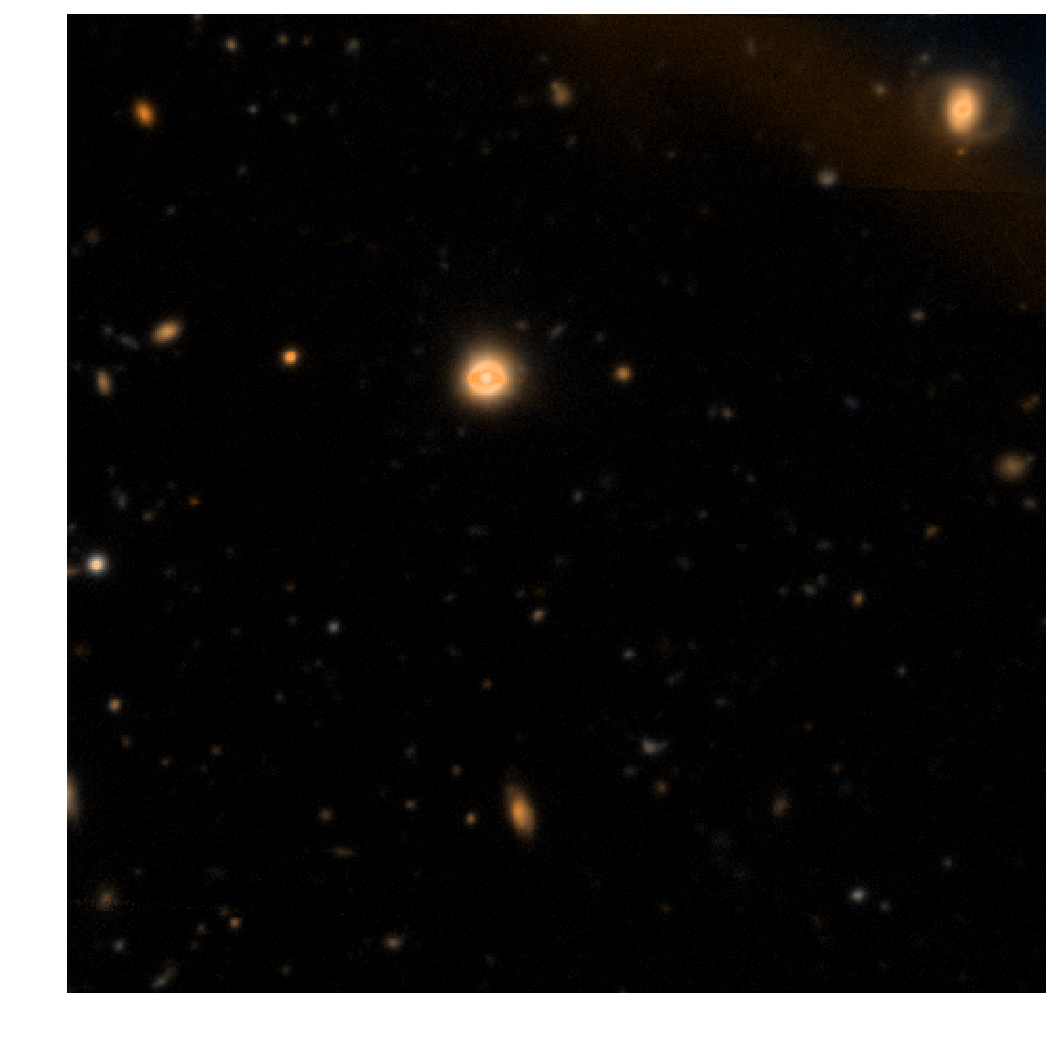

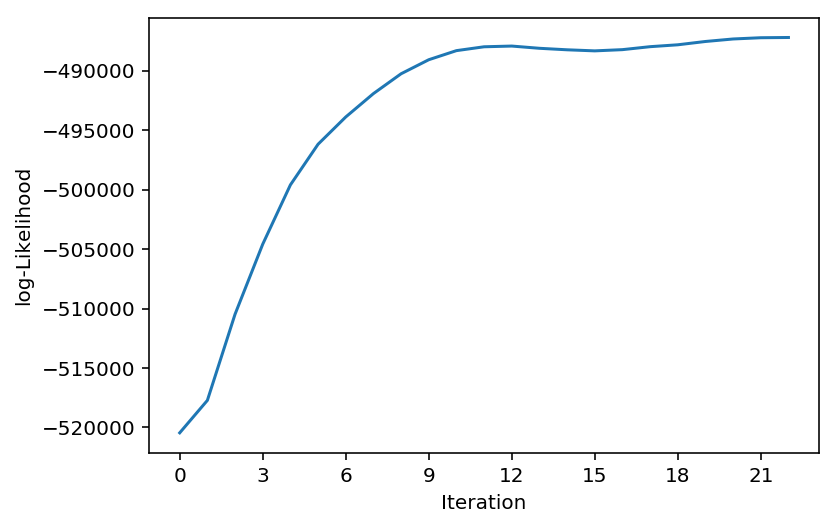

No flux in morphology model for source at (6.506924778485703, 49.53581612606549)
No flux in morphology model for source at (24.277492991947824, 26.84551682194915)
No flux in morphology model for source at (25.789042626101892, 170.19955166367146)
No flux in morphology model for source at (36.10923877389811, 87.30650376765317)
No flux in morphology model for source at (48.51332805980657, 20.253573452857246)
No flux in morphology model for source at (73.31144336782353, 143.82607521223136)
No flux in morphology model for source at (90.60967170317001, 210.6577675007749)
No flux in morphology model for source at (92.5775967019579, 134.8478355500931)
No flux in morphology model for source at (98.045303044087, 179.36874644531417)
No flux in morphology model for source at (97.05484030398532, 372.3642525840019)
No flux in morphology model for source at (106.93270913033868, 310.32562634667244)
No flux in morphology model for source at (101.95219711452927, 1.5320818369889386)
No flux in morphology

Fitting Blend model.
Scarlet ran for 13 iterations to logL = -486930.0724048046


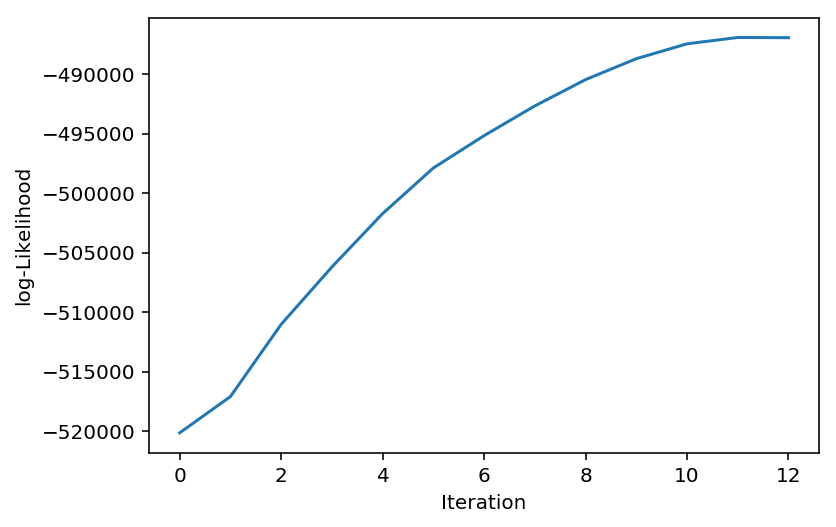

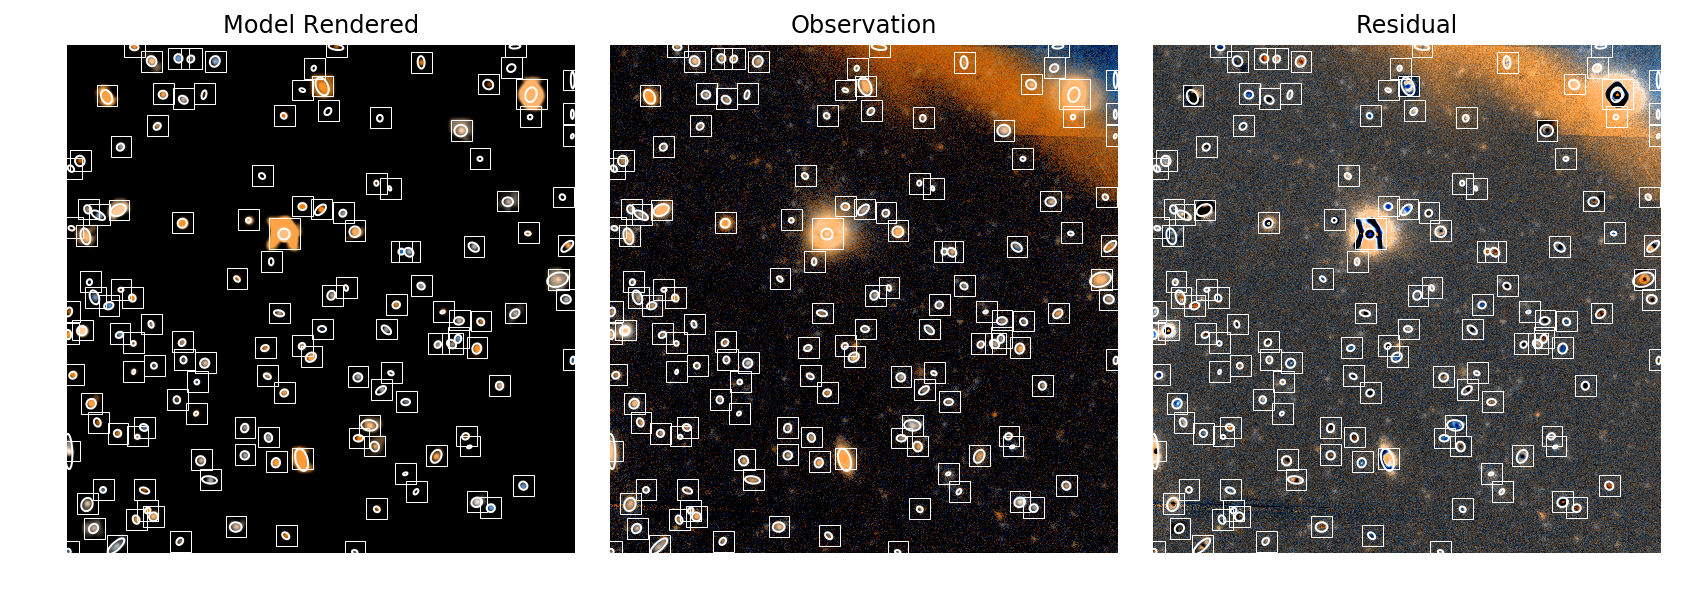

In [94]:
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

# Input coordinate
c = SkyCoord(151.3818, 2.5851, unit='deg')

# Get the HSC file info
hsc_dirpath = '/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/'

#tract, patch = get_tract_patch_from_coord(c)
print('Tract, patch from coord:', tract, patch)

filters = ['g', 'r']

# Get the HSC data from the file info
datas = get_hsc_data(dirpath=hsc_dirpath, filters=filters, tract=9813, patch=[2,1], plot_image=True, cutout_size=[512,512])

# Find good stretch and Q
plot_stretch_Q(datas)

# HSC Pixel scale arcsec/pixel
ps = 0.17
# Approximate PSF size in UD field according to HSC DR2 paper is 0.8 arcsec
sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
print('sigma_obs:', sigma_obs)

# Run Scarlet
# START TIMING with plotting OFF
observation, scarlet_sources = run_scarlet(datas, filters, sigma_model=1, sigma_obs=sigma_obs, plot_scene=True)
# END TIMING

# Save Scarlet data to FITS file
#write_scarlet_results(observation, scarlet_sources)

In [6]:
def generate_training_data(dirpath, bands=['g','r','i'], ratios=[1, 0.2, 0.2]):
    
    import glob
        
    # Normalize ratios to sum to 1
    ratios = ratios / np.sum(ratios)
    
    # Get all HSC data
    files = []
    b = bands[0]
    
    # /home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/**/**/**/calexp-HSC-G*.fits.gz
    files = glob.glob(os.path.join(dirpath, f'HSC-{b.upper()}/**/**/calexp-HSC-{b.upper()}-*.fits.gz'), recursive=True)
    # Randomize file order
    np.random.shuffle(files)
            
    # Split dataset into training, validation, and test using ratios
    ln = len(files)
    i_train = int(np.floor(ln*ratios[0]))
    i_val = int(np.floor(ln*ratios[1]))
    i_test = int(np.floor(ln*ratios[1]))
    
    # TODO: This looses a couple files
    files_train = files[:i_train]
    files_val = files[i_train:i_train + i_val]
    files_test = files[-i_test:]
    
    # Run scarlet on training and test datasets
    for i, f in enumerate([files_train, files_test]):
        
        # Get tract, patch (use first band)
        for fi in f:

            s = fi.split(f'calexp-HSC-{b.upper()}-')[1].split('.fits.gz')[0]
            tract, patch = s.split('-')
            patch = tuple(map(int, patch.split(',')))
            
            # Get the HSC data from the file info
            #datas = get_hsc_data(dirpath=hsc_dirpath, bands=bands, tract=tract, patch=patch)
            
            # TODO: Split data up into chunks if you need to

            # Run Scarlet
            #observation, scarlet_sources = run_scarlet(datas, plot_scene=True)

            # Save Scarlet data to FITS file
            #write_scarlet_results(observation, scarlet_sources)
        
    return files_train, files_val, files_test

In [156]:
generate_training_data(hsc_dirpath)